<font size="6">Fractional Processes & Spectral Density</font>

The goal of this notebook is to create a distance metric that takes into account the auto-correlation or power law decay LRD (long-range dependence) of the data, not just mean and variance or other statistical moments. Some type of simple optimization of this distance metric could act as a maximum likelihood estimator for fractional stochastic processes with a Hurst exponent. Then we can describe data generating processes (DGPs) by their spectral density characteristics. 

<font size="5">Don't Follow The Crowd</font> 

In developing strategy for something like stochastic financial markets, it pays to be contrarian. You never want to be the last to gain some information (or for instance, the last to discover a factor or to be late to discover a factor). You want to discover an emerging factor as early as possible. So it pays to believe that the price already reflects *almost* all available information. And that could be a very high almost, like 99.999% in some cases. 

If we model large shocks (e.g. March 2020) and then trace how the auto-correlation of the volatility of that shock decays over time, it creates a wave form because the volatility decays away but over sufficiently long timescales it then resurfaces again (usually in a way that makes sense given the macro-economic environment). This is a natural feature of the fact that too many investors pile into certain assets that are popular throughout one 'regime' but then that asset becomes saturated. Treasuries became saturated during the low rate QE pandemic regime which ultimately caused Silicon Valley Bank to take huge losses when inflation spiked. 

Goal is to view the markets as this spectral wave form instead of the price or just daily return; what you see on Google finance.

<font size="5">Causality</font>

How do we establish causality between sequential 'events' in a time series, we first need a stable definition of an 'event'. This is where things are a bit fuzzy for me, but reading into the paper below on Causality will help. My thinking is that the auto-correlation that comes with a market shock has to diffuse away before we can call that event complete in a way that allows us to say it then *causes* another event. If you look at the stock market each day and treat that as an event, the sample is actually auto-correlated to the past factors so maybe 'events' are longer running phenomena not anything you can track daily unless there is a new shock to the markets. But this is just a rough idea. In the paper he (Marcos Lopez de Prado - Can Factor Investing Become Scientific?) discusses the need to make the data generating process (DGP) explicit and how a theory should be falsifiable and tested against alternative interventions, which may be latent state generative models of the data. 

It would make sense with factors because any good factor for the future is likely to be discovered by others, even if we were to find it early. Volatility shocks are like ripples in an ocean providing information about investors finding these factors but if you get caught in the auto-correlation (the spectral characteristics of the volatility), you might just be *following the crowd*? The better thing to do is to have some type of falsifiable economic theory given the broader economic context. The wave forms below should be stationary in a cyclical sense (WSS/cyclo-stationary).

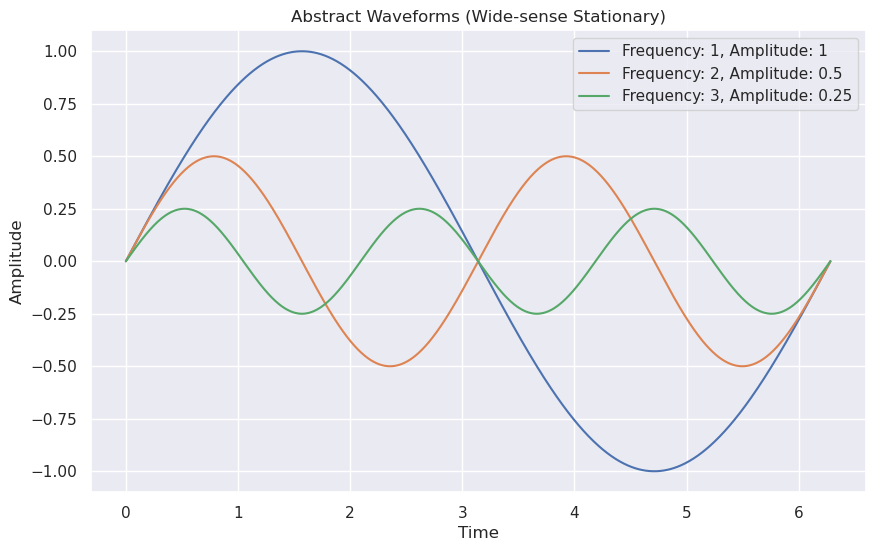

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def draw_waveforms():
    
    # Purely abstract waveforms to demonstrate a concept 
    t = np.linspace(0, 2*np.pi, 1000)
    
    # Define the frequencies and amplitudes for the waveforms
    freqs = [1, 2, 3] 
    amps = [1, 0.5, 0.25]  
    
    # Calculate 
    waveforms = [amp * np.sin(freq * t) for freq, amp in zip(freqs, amps)] 
    sns.set() 
    plt.figure(figsize=(10, 6)) 
    
    # Plot each waveform
    for waveform, freq, amp in zip(waveforms, freqs, amps):
        plt.plot(t, waveform, label=f"Frequency: {freq}, Amplitude: {amp}")
    
    plt.xlabel('Time')  
    plt.ylabel('Amplitude')  
    plt.title('Abstract Waveforms (Wide-sense Stationary)')  
    plt.legend()    
    plt.show() 

# 
draw_waveforms()

<font size="5">Ergodicity</font>

Even if two sets of data have the same distributional parameters the order of the data in terms of auto-covariance or some other auto-correlated parameter may not be the same. This is the auto-correlation decay in the time domain if we imagine things as a data generating process (DGP). 

Processes with long memory or periodic memory will not be ergodic especially if the auto-correlation decay is slow and follows a power law. So is it possible to have a maximum likelihood estimator that would compute likelihoods for the mean, variance, and auto-covariance of the data considered all together?

<font size="5">RBF Kernel</font>

Inspired partially by the work of these researchers,
http://cermics.enpc.fr/~guyon/documents/VolatilityIsMostlyPathDependent_Slides_RiO2022_22Aug2022.pdf

In this paper they discuss how kernels can learn the long or short-term memory of the volatility dynamics. I have some other papers that discuss similar ideas. 

<font size="5">Use Case in Factor Analysis</font>

'Endogenous volatility' described in the path-dependent volatility model above suggests that for any asset we look at, there is a strong effect based purely on the past (path-dependency, non-ergodicity, non-markovian dynamics). So it segues into causal ML and whether factor investing can become scientific. There are feedback effects that need to be taken into account. Maybe the best thing to do is to define features that remove the purely feedback effects which would just confuse a causal model. I'm still reading the paper below, it goes very deep into causal factor theory. 

Can Factor Investing Become Scientific? 

https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4205613

Lastly, Irrational Capital is a good example of a research/fund looking at deep ESG factors, 

https://www.irrational.capital/

In [4]:
%pip install torch
%pip install gpytorch
%pip install git+https://github.com/forrestbao/pyeeg.git
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

import sklearn 
import sklearn.mixture as mix 

import torch
import gpytorch
import pyeeg

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-7ylutv3n
  Running command git clone --filter=blob:none --quiet https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-7ylutv3n
  Resolved https://github.com/forrestbao/pyeeg.git to commit a6c18bb093e4748f9d9c208535a6ae024a0802b8
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [54]:
from scipy.fft import fft

assetlist = [ 'IEF', 'GSG', 'IXN' ]
num_components = 4

# View the power spectral density (PSD) squared magnitude
def view_spectrum(X): 
    sns.lineplot(data=fft(X))
    plt.show()
    
# FractionalPSD 
class FractionalPSD:
    def __init__(self, data):
        self.data = np.array(data)
        self.affinity_matrix = None

    # TODO Work in progress
    def distance_norm(self, target): 
        x1 = torch.tensor([ _x for _x in target ], dtype=torch.float)
        x0 = torch.tensor([ _x for _x in self.data  ], dtype=torch.float)
        
        # Evaluate kernel auto-covariance matrix (aka 'affinity matrix') 
        kernel = gpytorch.kernels.RBFKernel()
        autocov_1 = (kernel(x1).evaluate()).detach().numpy() 
        autocov_0 = (kernel(x0).evaluate()).detach().numpy()

        # Compute eigenvalues of the affinity matrix  
        eigenvalues_target = np.linalg.eigvalsh(autocov_1)
        eigenvalues_self = np.linalg.eigvalsh(autocov_0)
        
        # Generate samples from the exponential distribution for eigenvalues over threshold
        samples_target = np.random.exponential(scale=1/np.clip(eigenvalues_target, a_min=1e-1, a_max=None))
        samples_self = np.random.exponential(scale=1/np.clip(eigenvalues_self, a_min=1e-1, a_max=None))
        
        sns.distplot(samples_target)
        sns.distplot(samples_self)
        plt.show()
        
        # Wasserstein Distance
        return stats.wasserstein_distance(samples_target, samples_self)

Create the subset of assets. We end up with a 3-dimensional multivariate gaussian system. 

In [55]:
m6 = pd.read_csv('./data/assets.csv')
m6_assets = pd.DataFrame()

for sym in assetlist: 
    m6_assets[sym] = m6[m6['symbol'] == sym]['price'].values

<font size="5">Auto-Correlation Decay Plots</font>

(Hurst Exponent Auto-Covariance Function) 

$$\huge cov(s,t) = \frac{1}{2} \left( t^{2H} + s^{2H} - |t-s|^{2H} \right)$$

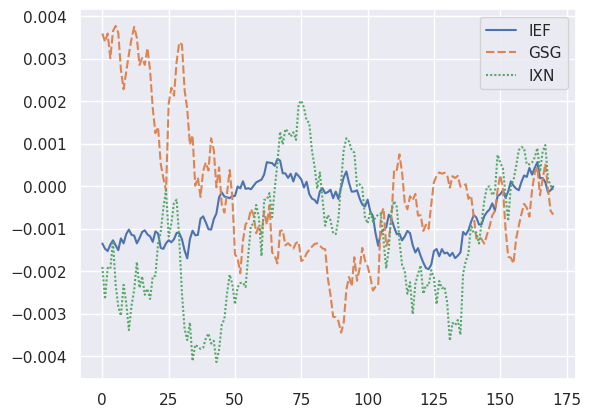

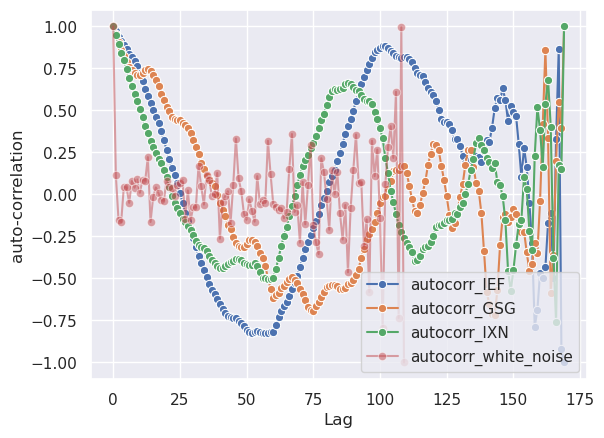

0.9899969478313461
1.0257723874745595


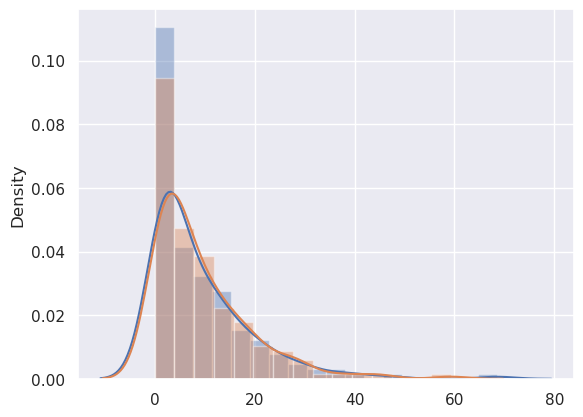

0.5544366785346073


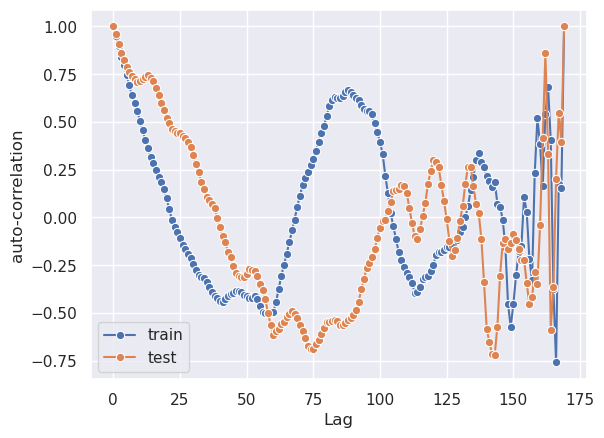

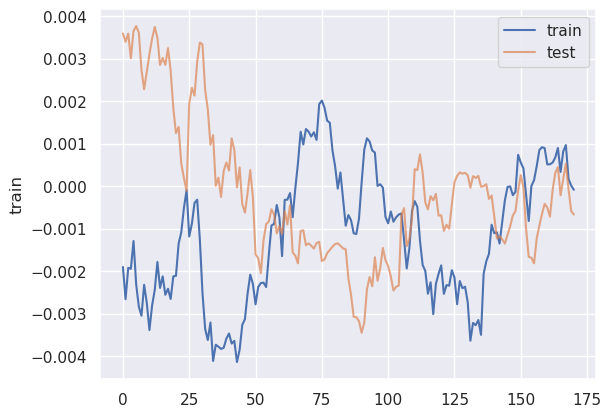

In [58]:
import scipy.stats as stats
import scipy 

m6_subset1 = m6_assets.copy()

# Window length 60 days
wlen = 60

# First convert to log price 
m6_subset1 = m6_subset1.apply(np.log)

# Clean data
m6_subset1 = m6_subset1.dropna().reset_index().drop(columns='index')

# Apply window 
#rolling_zscore = lambda serie: [ stats.zscore(serie[x-wlen:x]).values[-1] for x in range(wlen, len(serie) + 1) ]
rolling_mean = lambda serie: [ np.mean(serie[x-wlen:x]) for x in range(wlen, len(serie) + 1) ]

m6_subset = pd.DataFrame()
m6_subset['IEF'] = np.diff(rolling_mean(m6_subset1['IEF']))# - m6_subset1['IEF'][0]
m6_subset['GSG'] = np.diff(rolling_mean(m6_subset1['GSG']))# - m6_subset1['GSG'][0]
m6_subset['IXN'] = np.diff(rolling_mean(m6_subset1['IXN']))# - m6_subset1['IXN'][0]

# View Power Spectrum
#view_spectrum(m6_subset['IEF'].values)
#view_spectrum(m6_subset['GSG'].values)
#view_spectrum(m6_subset['IXN'].values)

# View Data
sns.lineplot(data=m6_subset)
plt.show() 

# Make Noise 
white_noise_d = torch.normal(0, 1, size=(len(m6_subset),))
white_noise_d = white_noise_d.detach().numpy()
white_noise = FractionalPSD(white_noise_d)
wd1f=pd.DataFrame() 
wd1f['X']=white_noise_d
wdf=pd.DataFrame()
wdf['X']=np.diff(rolling_mean(wd1f['X']))

# View Auto Correlation
decay_func = lambda S, _range: [S.autocorr(lag=Lag) for Lag in _range]
sns.lineplot(data=decay_func(m6_subset['IEF'], range(0, 200)), label='autocorr_IEF', marker='o') 
sns.lineplot(data=decay_func(m6_subset['GSG'], range(0, 200)), label='autocorr_GSG', marker='o')
sns.lineplot(data=decay_func(m6_subset['IXN'], range(0, 200)), label='autocorr_IXN', marker='o')
sns.lineplot(data=decay_func(wdf['X'], range(0, 200)), label='autocorr_white_noise', marker='o', alpha=0.5)
plt.xlabel('Lag')
plt.ylabel('auto-correlation')
plt.show()
    
# Example using Cross Spectrum (compare across assets -- cross section spectral analysis) 
from sklearn.model_selection import train_test_split
ixn = m6_subset['IXN']
gsg = m6_subset['GSG']
fdf=pd.DataFrame() 
fdf['train']=ixn
fdf2=pd.DataFrame()
fdf2['test']=gsg

ixnf = FractionalPSD(ixn)
print(pyeeg.hurst(fdf['train']))
print(pyeeg.hurst(fdf2['test']))
print(ixnf.distance_norm(gsg))
    
# View Auto Correlation 
sns.lineplot(data=decay_func(fdf['train'], range(0, 200)), label='train', marker='o') 
sns.lineplot(data=decay_func(fdf2['test'], range(0, 200)), label='test', marker='o')
plt.xlabel('Lag')
plt.ylabel('auto-correlation')
plt.show()
sns.lineplot(data=fdf['train'], label='train')
sns.lineplot(data=fdf2['test'], label='test', alpha=0.7)
plt.show()